In [1]:
import ROOT
from ROOT import RooRealVar,RooCBShape,RooDataHist,RooArgList,RooFit
from ROOT import gROOT,gStyle,gPad
from ROOT import std
import csv
import json
from array import array
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

import numpy as np


import sys
sys.path.insert(0, 'utils/')
import CBfunction as CB
reload(CB)
import CrystalMap as crystMap
reload(crystMap)
from uncertainties import unumpy
from uncertainties import ufloat
import pandas as pd

Welcome to JupyROOT 6.18/00


In [2]:
outstr = 'cb_gauss_simultaneous_float_cb'
#trees_path = '/eos/cms/store/group/dpg_ecal/comm_ecal/upgrade/testbeam/ECALTB_H4_Oct2018/ntuples_v5/'
trees_path = '/eos/user/n/nchernya/ntuples/ECAL/Upgrade/ECAL_TB_Oct2018/ntuples_v7/'

dir_str = '/28_08_2019/'
plot_folder = 'plots/'+dir_str
output_folder = 'output/'+dir_str
if not os.path.exists(plot_folder):
    os.makedirs(plot_folder)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [3]:
dict_C3_energy_scan = {}
##Now add runs for C2,C3,C4 
reader = csv.reader(open('data/energyscans19C.csv', 'r'))
for row in reader:
    run,energy,crystal,_,_,_ = row
    if crystal=='C3' :
        if energy in dict_C3_energy_scan.keys() :
            dict_C3_energy_scan[energy].append(run)
        else : 
            dict_C3_energy_scan[energy] = []
            dict_C3_energy_scan[energy].append(run)        

            
## Read crystal centers prepared by Simone 
reader = csv.reader(open('data/crystalscenters.csv', 'r'))
dict_crystal_centers={}
for row in reader:
    crystal,xpos,ypos = row
    if crystal!='Crystal' :
        dict_crystal_centers[crystal] = [int(xpos),int(ypos)]
        
dict_crystal_centers['C3_3x3'] =[4,5]       
        
naming = []
for i in range(5,0,-1):
    naming.append('A%d'%i)
    naming.append('B%d'%i)
    naming.append('C%d'%i)
    naming.append('D%d'%i)
    naming.append('E%d'%i)
missing = 'A5,A4,E5,E4'.split(',')
working = [item for item in naming]
for item in missing:
    working.remove(item)
    
matrix_3 = 'B4,C4,D4,B3,C3,D3,B2,C2,D2'.split(',')
matrix_5 = 'B5,C5,D5,B4,C4,D4,B3,C3,D3,B2,C2,D2,A1,B1,C1,D1,E1'.split(',')            

# Prepare time data for the minimization

In [4]:
crystal='C3'
energies = sorted([float(item) for item in dict_C3_energy_scan.keys()])
energies = [str(item) for item in energies]

round_energies = [round(float(energy),-1) for energy in energies]
if round_energies[-1] ==240 : round_energies[-1] = 250.

In [23]:
dict_df_energy = {}

for energy in energies:
    round_energy = round(float(energy),-1)
    if round_energy ==240 : round_energy = 250.
        
    runs = dict_C3_energy_scan[energy]
    tree = ROOT.TChain("h4")
    for run in runs:
        tree.Add("%s/ECAL_H4_October2018_%s.root"%(trees_path,run))
        pos_cut = 4
    data = []
    for evt in tree:
        if evt.fit_ampl[getattr(evt, crystal)]>1000 and evt.fit_ampl[evt.MCP1]>100 and evt.fit_ampl[evt.MCP2]>100 and evt.n_tracks==1 and abs(evt.X[0]-dict_crystal_centers[crystal][0])<pos_cut and abs(evt.Y[0]-dict_crystal_centers[crystal][1])<pos_cut : 
            evt_dict = {}
            e = round(float(evt.Energy),-1)
            if e ==240 : e = 250.
            evt_dict['Energy'] = e
            evt_dict['fit_ampl_MCP1'] = evt.fit_ampl[evt.MCP1]/evt.b_rms[evt.MCP1]
            evt_dict['fit_ampl_MCP2'] = evt.fit_ampl[evt.MCP2]/evt.b_rms[evt.MCP2]
            evt_dict['fit_time_MCP1'] = evt.fit_time[evt.MCP1]
            evt_dict['fit_time_MCP2'] = evt.fit_time[evt.MCP2]
            for xstal in ['C3']:
                evt_dict['fit_ampl_'+xstal] = evt.fit_ampl[getattr(evt, xstal)]
                evt_dict['noise_'+xstal] = evt.b_rms[getattr(evt, xstal)]
                evt_dict['fit_time_'+xstal] = evt.fit_time[getattr(evt, xstal)]
                evt_dict['fit_terr_'+xstal] = evt.fit_terr[getattr(evt, xstal)]
                evt_dict['dt_ecal_mcp1_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP1]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_ecal_mcp2_'+xstal] = ((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])-int((evt.fit_time[getattr(evt, xstal)]-evt.fit_time[evt.MCP2]+evt.fit_time[evt.VFE_CLK])/6.238)*6.238)*1000
                evt_dict['dt_mcp2_mcp1_'+xstal] = (evt.fit_time[evt.MCP2]-evt.fit_time[evt.MCP1])*1000.
    
            data.append(evt_dict)

    df = pd.DataFrame(data) 
    dict_df_energy[energy] = df

    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%s.csv'%(trees_path,int(round_energy))
    df.to_csv(pd_name)


In [5]:
### Only used when I dont want to rerun the dataframe creation (takes longer than read csv file)
dict_df_energy = {}
for energy in energies:
    round_energy = round(float(energy),-1)
    if round_energy ==240 : round_energy = 250
    pd_name = '%s/ECAL_H4_October2018_pandas_C3_%d.csv'%(trees_path,int(round_energy))
    df = pd.read_csv(pd_name)    
    dict_df_energy[energy] = df

## Event selection

In [6]:
dt_cut = 200
#Event selection
for energy in energies:
    df = dict_df_energy[energy]
    selection = ((abs(df['dt_ecal_mcp2_C3']-df['dt_ecal_mcp2_C3'].median())<dt_cut) & 
                 (abs(df['dt_ecal_mcp1_C3']-df['dt_ecal_mcp1_C3'].median())<dt_cut) & 
                 (abs(df['dt_mcp2_mcp1_C3']-df['dt_mcp2_mcp1_C3'].median())<dt_cut))
    dict_df_energy[energy] = df.loc[selection]

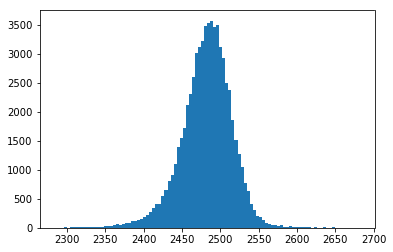

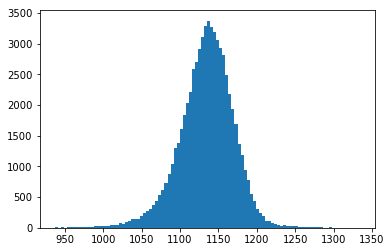

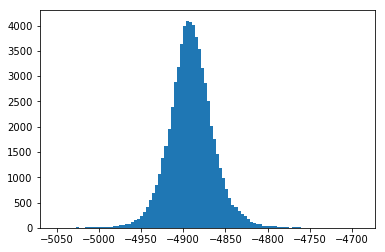

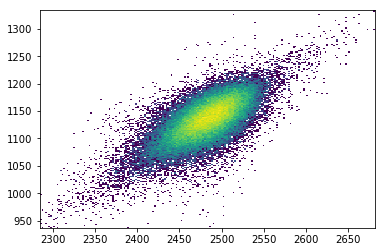

In [7]:
df = dict_df_energy[energies[-1]]  #which energy to plot

selection = (abs(df['dt_ecal_mcp2_C3']-df['dt_ecal_mcp2_C3'].median())<200) & (abs(df['dt_ecal_mcp1_C3']-df['dt_ecal_mcp1_C3'].median())<200) & (abs(df['dt_mcp2_mcp1_C3']-df['dt_mcp2_mcp1_C3'].median())<200)

plt.hist(df.loc[selection, 'dt_ecal_mcp1_C3'], bins=100)
plt.show()
plt.hist(df.loc[selection, 'dt_ecal_mcp2_C3'], bins=100)
plt.show()
plt.hist(df.loc[selection, 'dt_mcp2_mcp1_C3'], bins=100)
plt.show()
plt.hist2d(df.loc[selection, 'dt_ecal_mcp1_C3'], df.loc[selection, 'dt_ecal_mcp2_C3'], bins=[200,200], norm=colors.LogNorm())
plt.show()


In [8]:
gROOT.LoadMacro('utils/LLminimizer/LLminimizer.cc')


0

# Fitting energies one after another

In [ ]:
results_params = {}
for energy in energies:
    print 'Analyzing energy ',energy
    df = dict_df_energy[energy]
    time_minimizer = ROOT.LLminimizer(df['fit_ampl_MCP1'].shape[0],array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])),array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),array('d',list(df['dt_mcp2_mcp1_C3'])),array('d',list(df['Energy'])),crystal)
    time_minimizer.MinimizeNLL()
    res = {}
    res['Cm'] = [time_minimizer.m_Cm_,time_minimizer.m_Cm_e_]
    res['a1'] = [time_minimizer.m_a1_,time_minimizer.m_a1_e_]
    res['b1'] = [time_minimizer.m_b1_,time_minimizer.m_b1_e_]
    res['a2'] = [time_minimizer.m_a2_,time_minimizer.m_a2_e_]
    res['b2'] = [time_minimizer.m_b2_,time_minimizer.m_b2_e_]
    res['alpha'] = [time_minimizer.m_alpha_,time_minimizer.m_alpha_e_]
    res['beta'] = [time_minimizer.m_beta_,time_minimizer.m_beta_e_]
    res['gamma'] = [time_minimizer.m_gamma_,time_minimizer.m_gamma_e_]     
                                            
    results_params[energy] = res
    
from scipy import stats
#print results_params
cm_res = array('d')
energies_float = array('d')
cm_e_res = array('d')
energies_float_e = array('d')

beam_scan_resolution = 0.005

for energy in energies:
    cm_res.append(results_params[energy]['Cm'][0])
    cm_e_res.append(results_params[energy]['Cm'][1])
    energies_float.append(dict_df_energy[energy]['fit_ampl_C3'].median()/dict_df_energy[energy]['noise_C3'].mean())
    energies_float_e.append(1.)
    
keys = [float(e) for e in results_params]
keys.sort()
params = {}
for k in keys:
    print(k, results_params[str(k)])
    for name,par in results_params[str(k)].items():
        if name not in params:
            params[name] = []
        params[name].append(par[0])
        
for name, par in params.items():        
    plt.plot(keys, [(v-par[0])/par[0]*100 for v in par], label=name)
    plt.legend()
    plt.show()    


# Simultaneous fit of all energies

In [ ]:
results_params = {}

df = pd.concat([dict_df_energy[energy] for energy in energies],ignore_index=True)

time_minimizer = ROOT.LLminimizer(df['fit_ampl_MCP1'].shape[0],array('d',list(df['fit_ampl_MCP1'])),array('d',list(df['fit_ampl_MCP2'])),array('d',list(df['dt_ecal_mcp1_C3'])),array('d',list(df['dt_ecal_mcp2_C3'])),array('d',list(df['dt_mcp2_mcp1_C3'])),array('d',list(df['Energy'])),crystal)
time_minimizer.MinimizeNLLSimultaneous()
res = {}
res['Cm'] = [time_minimizer.m_Cm_,time_minimizer.m_Cm_e_]                      
res['a1'] = [time_minimizer.m_a1_,time_minimizer.m_a1_e_]
res['b1'] = [time_minimizer.m_b1_,time_minimizer.m_b1_e_]
res['a2'] = [time_minimizer.m_a2_,time_minimizer.m_a2_e_]
res['b2'] = [time_minimizer.m_b2_,time_minimizer.m_b2_e_]
res['alpha'] = [time_minimizer.m_alpha_,time_minimizer.m_alpha_e_]
res['beta'] = [time_minimizer.m_beta_,time_minimizer.m_beta_e_]
res['gamma'] = [time_minimizer.m_gamma_,time_minimizer.m_gamma_e_] 
res['alpha_cb1'] = [time_minimizer.m_alpha_cb1_,time_minimizer.m_alpha_cb1_e_]   
res['alpha_cb2'] = [time_minimizer.m_alpha_cb2_,time_minimizer.m_alpha_cb2_e_]   
res['n_cb1'] = [time_minimizer.m_n_cb1_,time_minimizer.m_n_cb1_e_]   
res['n_cb2'] = [time_minimizer.m_n_cb2_,time_minimizer.m_n_cb2_e_] 


In [22]:
from scipy import stats
#print results_params
cm_res = array('d')
energies_float = array('d')
cm_e_res = array('d')
energies_float_e = array('d')

beam_scan_resolution = 0.005

for num in range(0,len(res['Cm'][0])):
    energy = energies[num] 
    cm_res.append(res['Cm'][0][num])
    cm_e_res.append(res['Cm'][1][num])
    energies_float.append(dict_df_energy[energy]['fit_ampl_C3'].median()/dict_df_energy[energy]['noise_C3'].mean())
    energies_float_e.append(1.)

50.0 n_cb1 { 14.709830 }  , error =  { 1.4863981 }
50.0 a1 850.414836118  , error =  6.06407534643
50.0 a2 973.268825226  , error =  7.3628447071
50.0 alpha_cb1 { 1.6133414 }  , error =  { 0.019416523 }
50.0 b1 7.66872669413  , error =  0.304684142091
50.0 b2 14.9511627166  , error =  0.154358503304
50.0 alpha_cb2 { 1.5627103 }  , error =  { 0.018108323 }
50.0 gamma -4890.44798112  , error =  0.0620501090598
50.0 n_cb2 { 35.487665 }  , error =  { 7.5976000 }
100.0 n_cb1 { 14.709830 }  , error =  { 1.4863981 }
100.0 a1 850.414836118  , error =  6.06407534643
100.0 a2 973.268825226  , error =  7.3628447071
100.0 alpha_cb1 { 1.6133414 }  , error =  { 0.019416523 }
100.0 b1 7.66872669413  , error =  0.304684142091
100.0 b2 14.9511627166  , error =  0.154358503304
100.0 alpha_cb2 { 1.5627103 }  , error =  { 0.018108323 }
100.0 gamma -4890.44798112  , error =  0.0620501090598
100.0 n_cb2 { 35.487665 }  , error =  { 7.5976000 }
150.0 n_cb1 { 14.709830 }  , error =  { 1.4863981 }
150.0 a1 850.

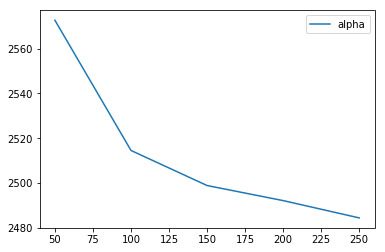

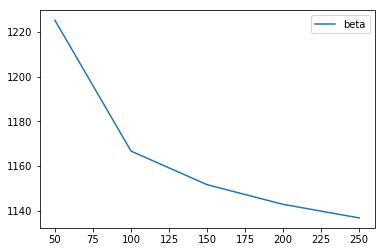

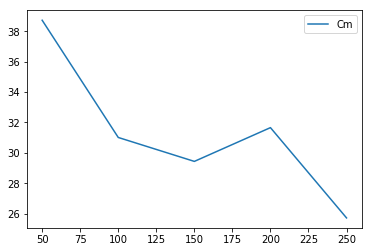

In [47]:
params = {}
#constants = 'a1,a2,b1,b2,gamma,alpha_cb1,alpha_cb2,n_cb1,n_cb2'.split(',')
constants = 'a1,a2,b1,b2,gamma'.split(',')
for num,energy in enumerate(round_energies):
    for name,par in res.items():
        if name in constants : 
            print energy, name,par[0],' , error = ',par[1]
        else : 
            params[name] = par[0]

        
for name, par in params.items():  
    plt.plot(round_energies, par, label=name)
    plt.legend()
    plt.show()

(49.99, {'Cm': [39.49577455375525, 0.19081513464457345], 'a1': [863.168342642, 15.789330272456596], 'beta': [1224.4345300165814, 0.3159401946422804], 'a2': [965.0932853466019, 18.6923931329448], 'b1': [6.387588940024401, 1.2791348360417678], 'b2': [15.91759726163539, 0.5015060939125799], 'alpha': [2572.1365234926006, 0.2918224179061326], 'gamma': [-4890.684604655596, 0.15434196927026278]})
(99.83, {'Cm': [30.816289754461476, 0.17850101684805253], 'a1': [838.3574763614123, 15.370633801339011], 'beta': [1166.7549192308948, 0.2770782626947721], 'a2': [939.7526143808194, 18.001323925828103], 'b1': [7.577301704442493, 0.7862529955191322], 'b2': [15.664604715891024, 0.3647793377801163], 'alpha': [2514.6366874378623, 0.2606630945369943], 'gamma': [-4890.450826587321, 0.15496347714451986]})
(149.12, {'Cm': [29.38602121434587, 0.14363486113674107], 'a1': [851.9378522367598, 12.802362163595717], 'beta': [1151.577842595041, 0.22459369224282], 'a2': [964.7136460384992, 15.720367228132147], 'b1': [

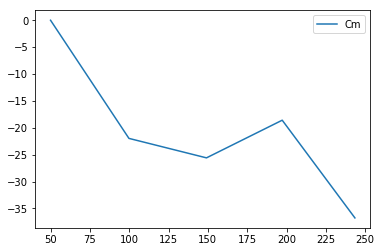

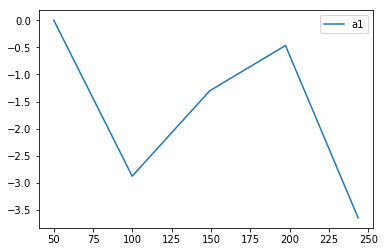

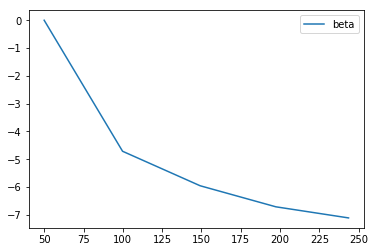

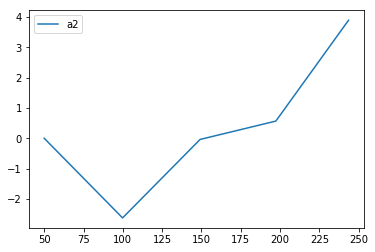

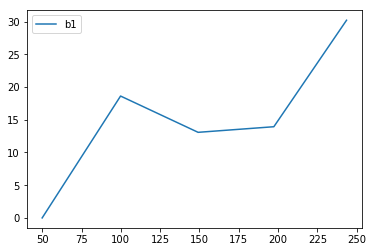

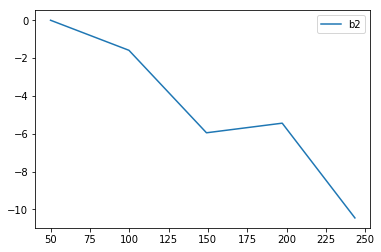

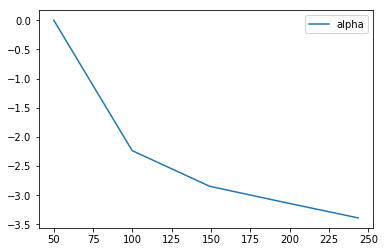

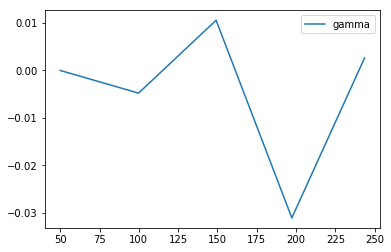

In [27]:
for name,par in res.items():
    print name, par[0]

n_cb1 { 14.709830 }
Cm { 38.717194, 31.016083, 29.443887, 31.662025, 25.730628 }
a1 850.414836118
beta { 1225.1867, 1166.6158, 1151.5706, 1142.7706, 1136.7017 }
a2 973.268825226
alpha_cb1 { 1.6133414 }
b1 7.66872669413
b2 14.9511627166
alpha_cb2 { 1.5627103 }
alpha { 2572.7605, 2514.5033, 2498.8141, 2492.0728, 2484.3304 }
gamma -4890.44798112
n_cb2 { 35.487665 }


# Plot time resolution

In [20]:
gROOT.ProcessLineSync(".x utils/setTDRStyle.C")
gROOT.ForceStyle()
gStyle.SetPadTopMargin(0.06)
gStyle.SetPadRightMargin(0.04)
gStyle.SetPadLeftMargin(0.2)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: pdf file plots//28_08_2019//time_res_cb_gauss_simultaneous.pdf has been created
Info in <TCanvas::Print>: png file plots//28_08_2019//time_res_cb_gauss_simultaneous.png has been created


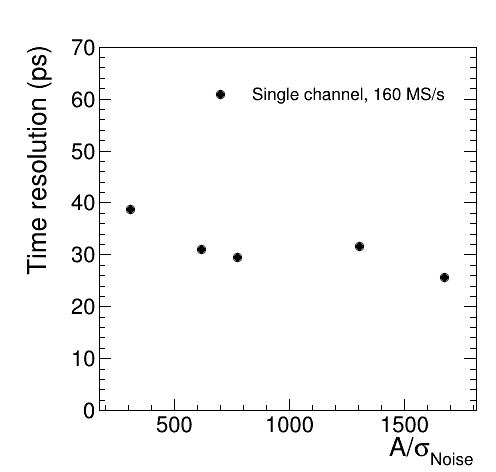

In [23]:
c1 = ROOT.TCanvas("c","c",500,500)
c1.SetTickx(0)


gres = ROOT.TGraphErrors(len(energies_float), energies_float , cm_res, energies_float_e, cm_e_res)
gres.SetTitle(";A/#sigma_{Noise}; Time resolution (ps)")
gres.Draw("AP")
gres.GetXaxis().SetNdivisions(507)
gres.GetYaxis().SetRangeUser(0, 70)
gres.Draw("AP")
st = gres.GetListOfFunctions().FindObject("stats")
#st.Delete()
lg = ROOT.TLegend(0.38, 0.7, 0.9, 0.9)
lg.AddEntry(gres, "Single channel, 160 MS/s", "p")
lg.SetFillStyle(-1)
lg.SetBorderSize(0)
lg.SetTextFont(42)
lg.SetTextSize(0.04)
lg.Draw("same")
c1.Draw()

c1.SetTopMargin(0.1)
c1.Draw()
c1.SaveAs('%s/time_res_%s.pdf'%(plot_folder,outstr))
c1.SaveAs('%s/time_res_%s.png'%(plot_folder,outstr))


## Plot time differences

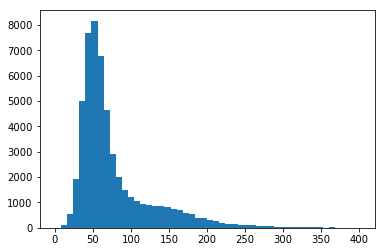

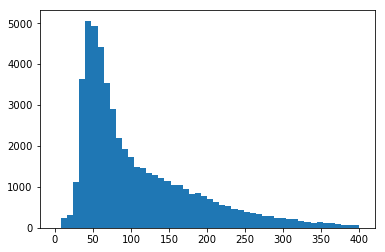

/usr/local/bin/start_ipykernel.py:18: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


2.166136154058186 9.002890616363604 -4889.6730844016165 27.385992845796466


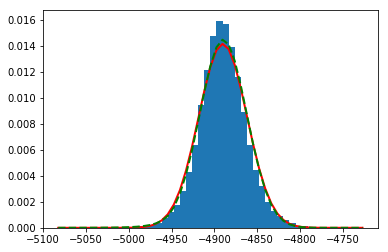

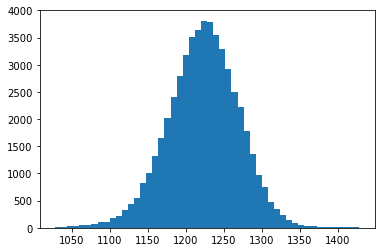

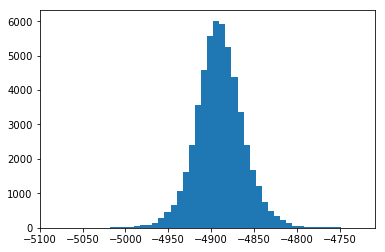

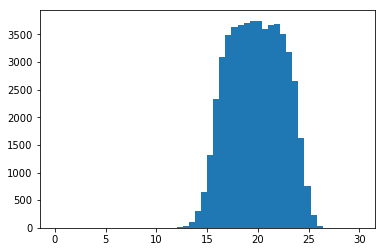

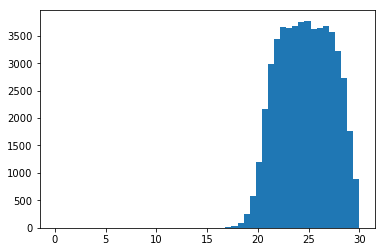

44.69972087432119


In [15]:
df = dict_df_energy[energies[0]]  #which energy to plot

plt.hist(list(df['fit_ampl_MCP1']),bins=50,range=[0,400])
plt.show()
plt.hist(list(df['fit_ampl_MCP2']),bins=50,range=[0,400])
plt.show()


from scipy.stats import norm
import matplotlib.mlab as mlab
#val = list(df.loc[(df.dt_ecal_mcp1_C3>2400) & (df.dt_ecal_mcp1_C3<2600)]['dt_ecal_mcp1_C3'])
val = list(df['dt_mcp2_mcp1_C3'])

n,bins,_ = plt.hist(val,bins=50,normed=1)
# best fit of data
(mu, sigma) = norm.fit(val,loc=2482.814488891773,scale=30.)
# add a 'best fit' line
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r-', linewidth=2)

from scipy.stats import crystalball
# best fit of data
beta, cb_m, loc, scale = crystalball.fit(val,loc=2482.814488891773,scale=30.)
# add a 'best fit' line
y = crystalball.pdf( bins, beta, cb_m, loc, scale)
l = plt.plot(bins, y, 'g--', linewidth=2)
print beta,cb_m,loc,scale
plt.show()


plt.hist(list(df['dt_ecal_mcp2_C3']),bins=50)
plt.show()
plt.hist(list(df['dt_mcp2_mcp1_C3']),bins=50)
plt.show()
plt.hist(list(df['fit_time_MCP2']),bins=50,range=[0,30])
plt.show()
plt.hist(list(df['fit_time_MCP1']),bins=50,range=[0,30])
plt.show()

print(df['dt_ecal_mcp1_C3'].std())

In [ ]:
for energy in energies:
    df = dict_df_energy[energy]
    print "dt1 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp1_C3'].mean(),df['dt_ecal_mcp1_C3'].std(),(df['dt_ecal_mcp1_C3'].quantile(0.75)-df['dt_ecal_mcp1_C3'].quantile(0.25))/2)
    print "dt2 : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_ecal_mcp2_C3'].mean(),df['dt_ecal_mcp2_C3'].std(),(df['dt_ecal_mcp2_C3'].quantile(0.75)-df['dt_ecal_mcp2_C3'].quantile(0.25))/2)
    print "dt12MCP : energy %s, mean = %.3f, std = %.3f, (75%-25%)/2 = %.3f"%(energy,df['dt_mcp2_mcp1_C3'].mean(),df['dt_mcp2_mcp1_C3'].std(),(df['dt_mcp2_mcp1_C3'].quantile(0.75)-df['dt_mcp2_mcp1_C3'].quantile(0.25))/2)
    print 